In [38]:
import fastf1 as ff
from fastf1 import plotting 
import pandas as pd 
from matplotlib import pyplot 
from matplotlib.pyplot import figure 
from matplotlib import cm 
import numpy as np 
import os 
from datetime import datetime as dt 
import argparse 
import warnings
from math import floor as fl 

debug = True 
if debug: 
    warnings.filterwarnings('ignore')
    warnings.simplefilter('ignore')

In [ ]:
ff.Cache.enable_cache('/Users/rantonyainarakotondrajoa/f1-laptimes/.cache')

In [ ]:
# loading the particular session  

session = 'R'
GP = 'Abu Dhabi'

schedule = ff.get_event_schedule(2022) 
race = schedule.get_event_by_name(GP)
race = race.get_session(session) 

In [ ]:
# retrieving data

laps = race.load_laps() # loading laptimes 
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds() 

# outlier handling (pitstops) using statistic iqr method 
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)
inter = q75 - q25
laptime_max = q75 + (1.5 * inter) 
laptime_min = q25 - (1.5 * inter) 

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan


## Drivers laptime comparison for AbuDhabi Grand Prix Race 

Drivers to show: ver rus nor vet mag


Text(0.5, 0.98, 'Abu Dhabi Grand Prix')

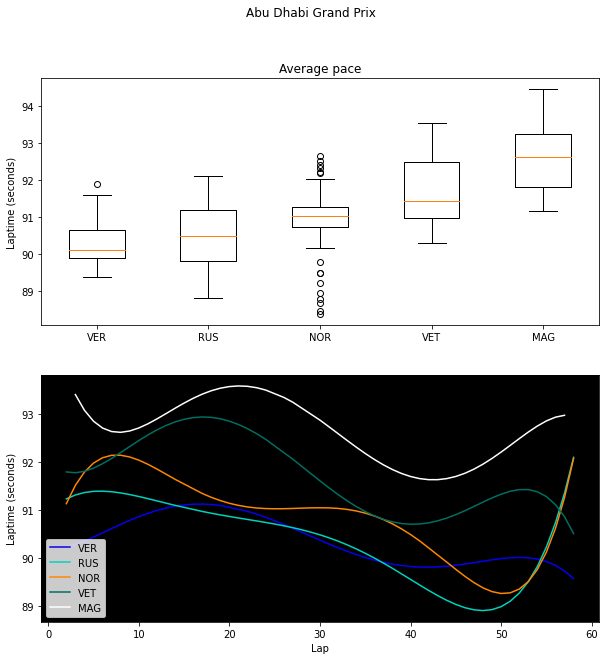

In [43]:
# plotting the result 

drivers = [d.upper() for d in input("Drivers to show: ").split(" ")]

pyplot.rcParams['figure.figsize'] = [10, 10]
fig, ax = pyplot.subplots(2)

laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers]
ax[0].boxplot(laptimes, labels=drivers)
        
ax[0].set_title('Average pace')
ax[0].set(ylabel='Laptime (seconds)')

# to store the teams we have seen 
teams = []

# laptimes (lap-by-lap)
for driver in drivers:
    try: 
        driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
        driver_laps = driver_laps.dropna()
        team = pd.unique(driver_laps['Team'])[0]
        x = driver_laps['LapNumber']
        poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
        y_poly = np.poly1d(poly)(driver_laps['LapNumber'])

        linestyle = '-' if team not in teams else ':'
        # labels and headers
        ax[1].plot(x, y_poly, label=driver, color=ff.plotting.team_color(team), linestyle=linestyle)
        

        ax[1].legend()
        if team not in teams:
            teams.append(team)
            
    except IndexError: 
        pass

if 'Haas F1 Team' in teams:
    ax[1].set_facecolor("black")
   
ax[1].set(ylabel='Laptime (seconds)')
ax[1].set(xlabel='Lap')
fig.suptitle(f"{race.event['EventName']}")
